In [ ]:
# https://towardsdatascience.com/a-table-detection-cell-recognition-and-text-extraction-algorithm-to-convert-tables-to-excel-files-902edcf289ec

In [1]:
import numpy as np
import math
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

#from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.layers import *

from keras.applications import MobileNetV2
from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json

from keras.models import load_model

In [2]:
target_size = [608, 608]
target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

grid_size = [19, 19]
grid_y_axis = 19  # each image is to be segmented to 17 x 17 grid
grid_x_axis = 19  # # each image is to be segmented to 17 x 17 grid

grid_stride = target_w / grid_x_axis  # grid cell width
grid_stride = target_h / grid_y_axis  # grid cell height

channels = 3
num_anchors = 3
class_num = 5 # vendor, invoice, inv_date, po, buyer
info = 5 + class_num    # pc, x, y, h, w, and class probabilities

categories = ['item'] # details of classes

In [3]:
# Making a list of image path

inv_directory = '/home/scar3crow/Downloads/drg_all'   
                                                        
inv_new_image = ['/home/scar3crow/Downloads/drg_all/{}'.format(i) for i in os.listdir(inv_directory)] # making the list
inv_new_image.sort() # Sorting the list

num_images = len(inv_new_image)

print('Number of images = ', num_images)


Number of images =  40


In [4]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_new = pd.DataFrame()

for i in range(len(inv_new_image)):
    image = cv2.imread(inv_new_image[i]) ## Loading image
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(inv_new_image[i])
        
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_new.insert(loc=0, column='image_serial', value=image_num)
df_new.insert(loc=1, column='rows', value=row_values)
df_new.insert(loc=2, column='columns', value=col_values)

df_new.tail(3)

,image_serial,rows,columns
37,/home/scar3crow/Downloads/drg_all/7.jpg,2480,3509
38,/home/scar3crow/Downloads/drg_all/8.jpg,2480,3509
39,/home/scar3crow/Downloads/drg_all/9.jpg,2480,3509


In [5]:
# Loading output of VGG Image Annotation tool and create a dataframe

r_new_data = pd.DataFrame()

r_new_data = pd.read_csv('/home/scar3crow/Downloads/via_drg_1.csv')


#r_new_data = pd.concat([r_new_data_1, r_new_data_2], axis = 0, ignore_index = True)

num_obj = r_new_data['region_count'][0] # number of objects in each photo
r_new_data.drop(r_new_data.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data = r_new_data[(r_new_data['#filename'] != '33.jpg') & (r_new_data['#filename'] != '20.jpg')].reset_index(drop=True)

r_new_data.sort_values(by=['#filename'], ascending=True) # Sorting based on image-id
num_images = r_new_data["#filename"].nunique() # Find out number of unique images

print('Number of unique images = ', num_images)
r_new_data.head(5)

Number of unique images =  38


,#filename,region_shape_attributes,region_attributes
0,1.jpg,"{""name"":""rect"",""x"":1886,""y"":1863,""width"":1457,...","{""text"":""item""}"
1,2.jpg,"{""name"":""rect"",""x"":2230,""y"":1615,""width"":1243,...","{""text"":""item""}"
2,3.jpg,"{""name"":""rect"",""x"":2143,""y"":1855,""width"":1200,...","{""text"":""item""}"
3,4.jpg,"{""name"":""rect"",""x"":2071,""y"":1840,""width"":1393,...","{""text"":""item""}"
4,5.jpg,"{""name"":""rect"",""x"":2224,""y"":1330,""width"":1140,...","{""text"":""item""}"


In [6]:
# Making a dataframe for Image_id, x, y, width, height, class, image_width and image_height

x = []
y = []
width = []
height = []
obj_class = []
i_width = []
i_height = []
img_path = []
img_index = []

for i in range(len(r_new_data)):
    
    r_size = r_new_data.values[i, 1][1:(len(r_new_data.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_new_data.values[i, 2][1:(len(r_new_data.values[i, 2])-1)]
    r_attribs_par = r_attribs.split(':')[1]
    obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    
    foto_id = r_new_data['#filename'][i]

    i_path = '/home/scar3crow/Downloads/drg_all/' + foto_id
    foto_index = int(df_new[df_new['image_serial'] == i_path].index[0])
    foto_width = df_new['columns'][foto_index]
    foto_height = df_new['rows'][foto_index]
    i_width.append(foto_width)
    i_height.append(foto_height)
    img_path.append(i_path)
    img_index.append(foto_index)
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)
img_path_values = pd.Series(img_path)
img_index_values = pd.Series(img_index)

r_new_data.insert(loc=1, column='img_idx', value=img_index_values)
r_new_data.insert(loc=2, column='i_path', value=img_path_values)
r_new_data.insert(loc=3, column='x', value=x_values)
r_new_data.insert(loc=4, column='y', value=y_values)
r_new_data.insert(loc=5, column='width', value=width_values)
r_new_data.insert(loc=6, column='height', value=height_values)
r_new_data.insert(loc=7, column='obj_class', value=class_values)
r_new_data.insert(loc=8, column='img_wd', value=i_width_values)
r_new_data.insert(loc=9, column='img_ht', value=i_height_values)

r_new_data.drop(r_new_data.columns[[10, 11]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

r_new_data[0:3]


,img_id,img_idx,i_path,x,y,width,height,obj_class,img_wd,img_ht
0,1.jpg,0,/home/scar3crow/Downloads/drg_all/1.jpg,1886,1863,1457,107,item,3509,2480
1,2.jpg,11,/home/scar3crow/Downloads/drg_all/2.jpg,2230,1615,1243,410,item,3509,2480
2,3.jpg,22,/home/scar3crow/Downloads/drg_all/3.jpg,2143,1855,1200,115,item,3509,2480


In [74]:

r_new_data[37:38]

,img_id,img_idx,i_path,x,y,width,height,obj_class,img_wd,img_ht
37,37.jpg,30,/home/scar3crow/Downloads/drg_all/37.jpg,1586,355,1872,1676,item,3509,2480


In [7]:
## Find out image with max boxes :

max_box_image = r_new_data['img_id'].value_counts().max()
image_with_max_box =  r_new_data['img_id'].value_counts().idxmax()
print(image_with_max_box, 'with', max_box_image, 'boxes')

28.jpg with 3 boxes


In [8]:
print('Number of unique images = ', r_new_data['img_id'].nunique())  # print total no, of unique images
print('Number of classes in diff. categories = ', r_new_data['obj_class'].value_counts())

Number of unique images =  38
Number of classes in diff. categories =  item    42
Name: obj_class, dtype: int64


In [9]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    line_idx = lines.iat[0, 1]
    pic_path = lines.iat[0, 2]
    img_width = lines.iat[0, 8]
    img_height = lines.iat[0, 9]
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        index_of = lines['obj_class'][i]
        label = categories.index(index_of)
        x_min, y_min, x_max, y_max = float(lines.iat[i,3]), float(lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5]), float(lines.iat[i,4]+lines.iat[i,6])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.int64)
    
    return line_idx, pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [238]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0
for i in range(num_images):
    image_line = []
    
    img = r_new_data['img_id'][limit_upper]
    kount = r_new_data['img_id'].value_counts()[img]
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = r_new_data[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
    image_line.append(line_idx)
    image_line.append(pic_path)
    image_line.append(boxes)
    image_line.append(labels)
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[21])   ##  boxes are in format xmin, ymin, xmax, ymax

38
[15, '/home/scar3crow/Downloads/drg_all/23.jpg', array([[1921., 1650., 3349., 1973.]], dtype=float32), array([0]), 3509, 2480]


In [ ]:
print(all_image_line[11])

In [11]:
## Draw Box with sharpened image :

def draw_box_pred(img_id, box_list, label, target_size):
    
    image_id = str(img_id) + '.jpg'
#    print(image_id)
    image_path = '/home/scar3crow/Downloads/drg_all/' + image_id
#    print(image_path)

# find index of image in data frame :
    """
    image_list = r_new_data['img_id'].unique() # make a list of unique images
    idx = [i for i in range(len(image_list)) if image_list[i] == image_id] # find index of image
    """
# reading image and resizing as per target image :

    x = cv2.imread(image_path)
    x_ratio = target_size[1] / x.shape[1]
    y_ratio = target_size[0] / x.shape[0]

    xx = cv2.resize(x, (target_size[1], target_size[0]))
#    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#    xx = cv2.filter2D(xx, -1, kernel)
#    xx = unsharp_mask(xx)
    """
    print('======================', xx.max())
    print('======================', xx.min())
    
# slicing as per current image id

    r_new_data_slice = r_new_data.loc[r_new_data['img_id'].isin([image_list[idx[0]]])].reset_index(drop=True) 

    m = int(target_size[1] / grid_size[1])  # making x-scale for making grid
    n = int(target_size[0] / grid_size[0])  # making x-scale for making grid

    x_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14, m*15, m*16, m*17, m*18] 
    y_range = [0, n*1, n*2, n*3, n*4, n*5, n*6, n*7, n*8, n*9, n*10, n*11, n*12, n*13, n*14, n*15, n*16, n*17, n*18 ]

    for i in x_range:
            for j in y_range:
                cv2.rectangle(xx, (i, j), (i+32, j+32), 0, 2)
            
    for j in range(len(r_new_data_slice)):
    """
    for j in range(len(box_list)):
        
        xmin = int(box_list[j][0])
        ymin = int(box_list[j][1])
    
        xxmin = int(xmin * x_ratio)
        yymin = int(ymin * y_ratio)
 
        xmax = int(box_list[j][2])
        ymax = int(box_list[j][3])
    
        xxmax = int(xmax * x_ratio)
        yymax = int(ymax * y_ratio)
        
        obj_class = categories[int(label[j])]
    
#        print(xmin,ymin,xmax,ymax,xxmin,yymin,xxmax,yymax, obj_class)
        
        cv2.rectangle(x, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(x, obj_class, (xmin+10,ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 0, 255), 2)
    
    
        cv2.rectangle(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.putText(xx, obj_class, (xxmin+10,yymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
        cv2.line(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.line(xx, (xxmin, yymax), (xxmax, yymin), (255, 0, 0), 2)
        
    
    x_pil = Image.fromarray(x)
#    display(x_pil)

    xx_pil = Image.fromarray(xx)
#    display(xx_pil)

    return(display(x_pil))   #, display(xx_pil))

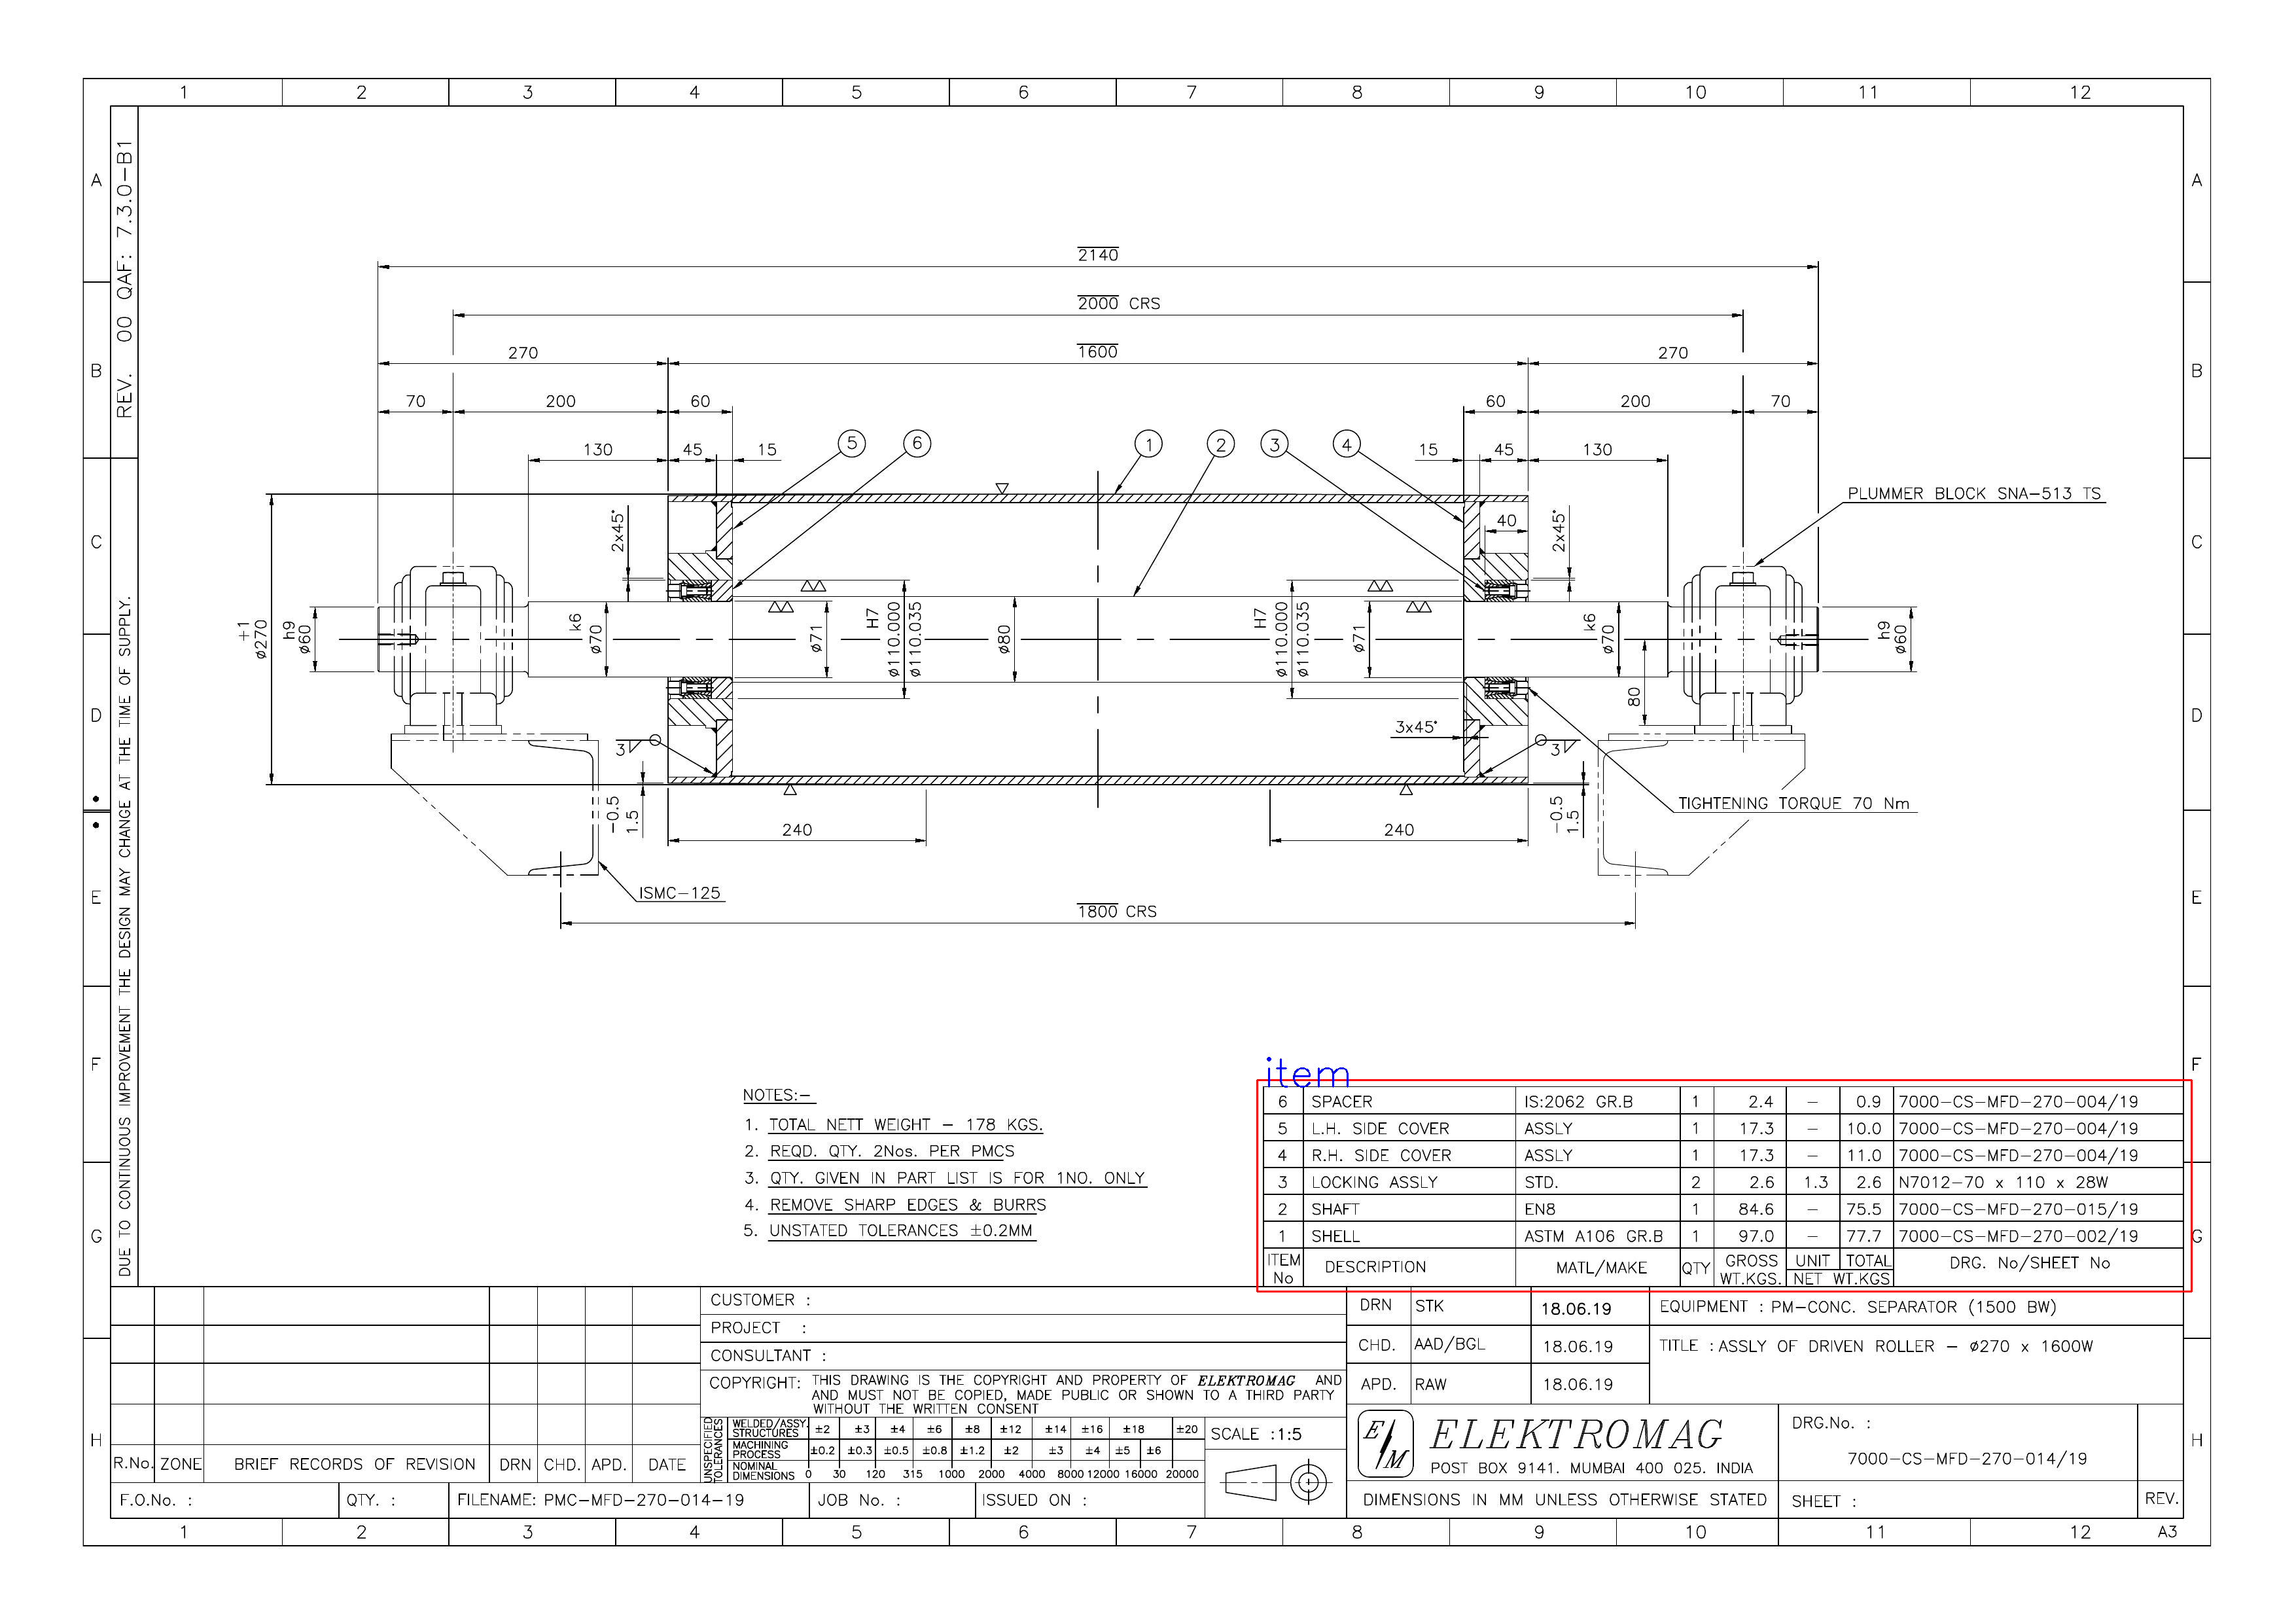

In [239]:
_,_,box_list,label,_,_ = all_image_line[21]

img_id = 23

draw_box_pred(img_id, box_list,label, target_size)


[[1921. 1650. 3349. 1973.]]


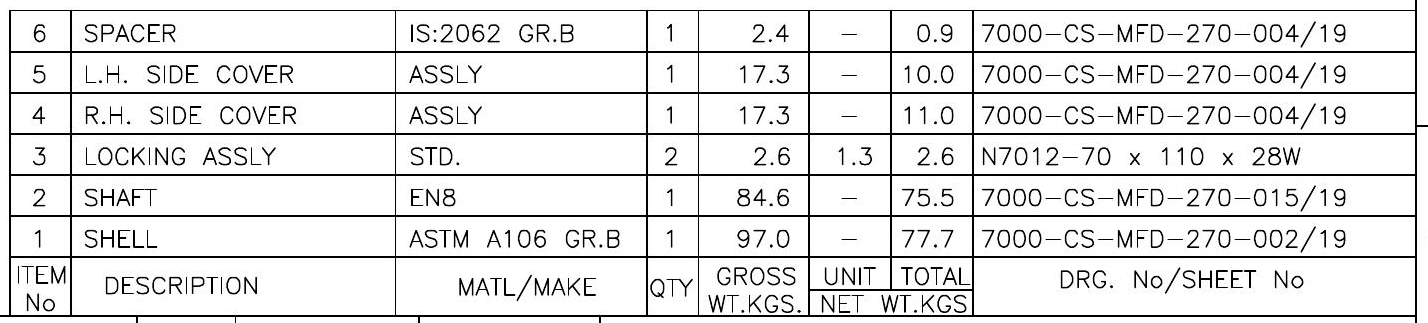

In [240]:
img_id = 23
image_id = str(img_id) + '.jpg'

image_path = '/home/scar3crow/Downloads/drg_all/' + image_id

_,_,box_list,label,_,_ = all_image_line[21]
#box_list = box_list.tolist()

print(box_list)

x = cv2.imread(image_path)

xx = x[int(box_list[0][1]):int(box_list[0][3]), int(box_list[0][0]):int(box_list[0][2])]
xx_gray = cv2.cvtColor(xx,cv2.COLOR_BGR2GRAY)

xx_pil = Image.fromarray(xx_gray)

display(xx_pil) 

In [15]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    

    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [16]:
xx_gray_sharp = unsharp_mask(xx_gray)

In [17]:
text_0 = pytesseract.image_to_string(xx_gray_sharp)
print(text_0)


SEAMLESS PIPE #273 x 9.3THK x RW+10 LG.

ASTM _ A106 GR.B

 

 

ITEM
No

 

DESCRIPTION

 

MATL/MAKE

 

QTY

UNIT

 

[TOTAL

 

 

NET WTKGS

 

DRG. No/SHEET No


In [ ]:
# https://towardsdatascience.com/a-table-detection-cell-recognition-and-text-extraction-algorithm-to-convert-tables-to-excel-files-902edcf289ec
    

In [17]:
#thresh,img_bin = cv2.threshold(xx,0,255,cv2.THRESH_BINARY)

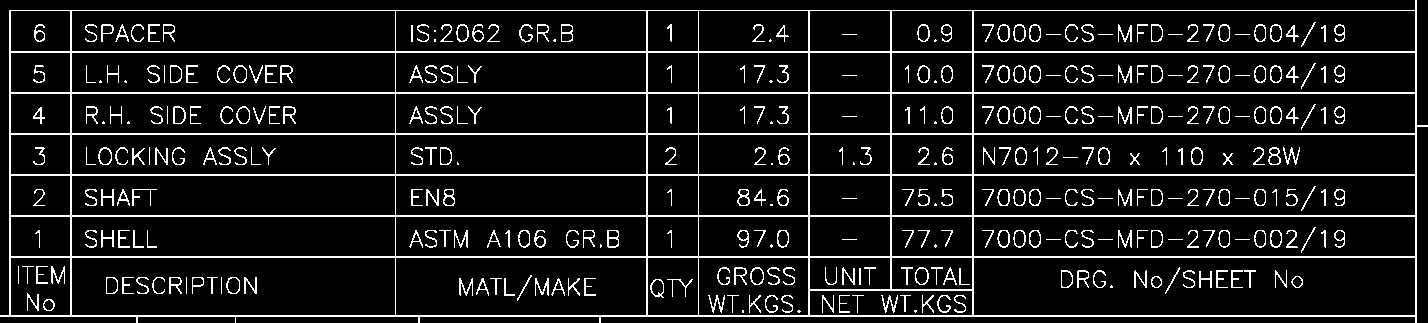

In [241]:
#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(xx_gray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#inverting the image 
img_bin_invert = 255-img_bin

# cv2.imwrite('/Users/YOURPATH/cv_inverted.png',img_bin)
#Plotting the image to see the output
#plotting = plt.imshow(img_bin,cmap='gray')
#plt.show()

img_pil = Image.fromarray(img_bin_invert)

display(img_pil) 

In [26]:
text_1 = pytesseract.image_to_string(img_bin_invert)
print(text_1)


SEAMLESS PIPE #273 x 9.3THK x RW+10 LG.

ASTM _ A106 CR.B

 

 

ITEM
No

 

DESCRIPTION

 

MATL/MAKE

 

QTY

Noi

 

Lerale

 

 

NET WTKGS

 

DRG. No/SHEET No


In [242]:
# Length(width) of kernel as 100th of total width
kernel_len = xx_gray.shape[1]//100
print(xx_gray.shape)
print(kernel_len)

(323, 1428)
14


In [243]:
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
ver_kernel.shape

(14, 1)

In [244]:
ver_kernel

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [245]:
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
hor_kernel.shape

(1, 14)

In [246]:
hor_kernel

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

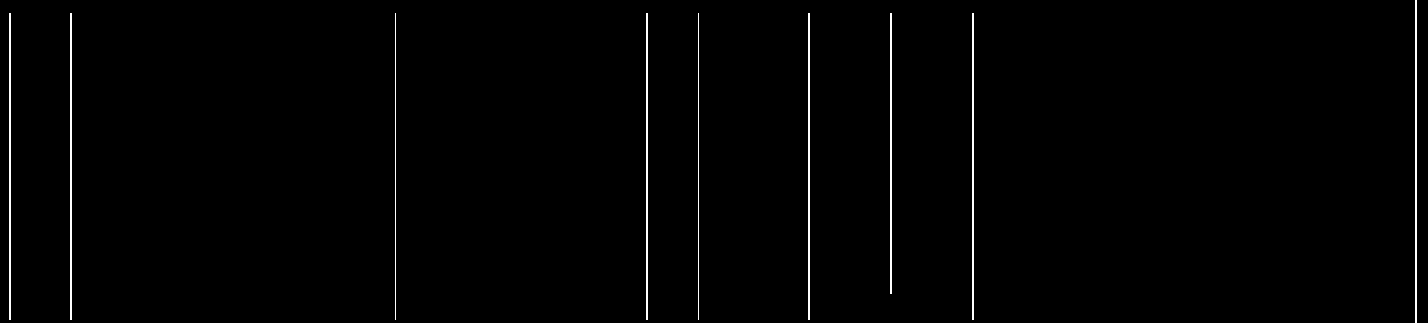

In [247]:
#Use vertical kernel to detect and save the vertical lines in a jpg

image_1 = cv2.erode(img_bin_invert, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

v_lines_pil = Image.fromarray(vertical_lines)

display(v_lines_pil)  


In [41]:
aa = np.ones((18,1), dtype=np.uint8)

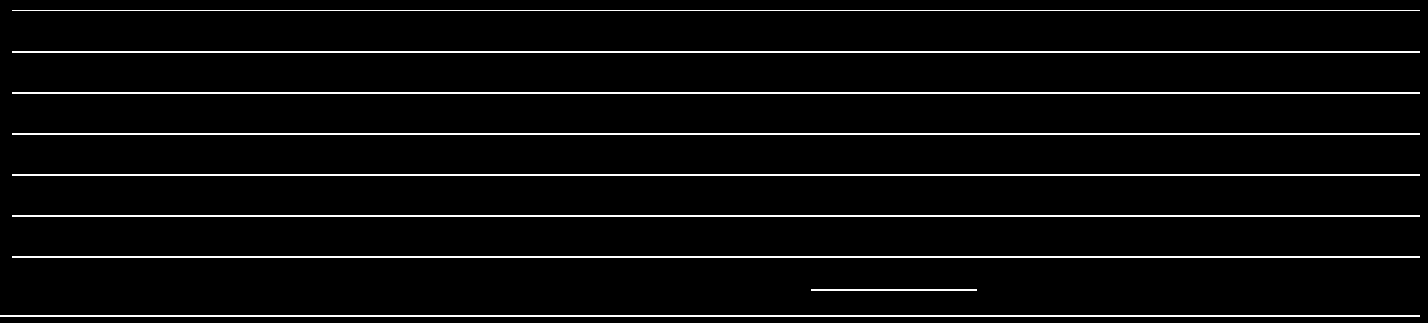

In [248]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin_invert, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

h_lines_pil = Image.fromarray(horizontal_lines)

display(h_lines_pil) 



[[1 1]
 [1 1]]


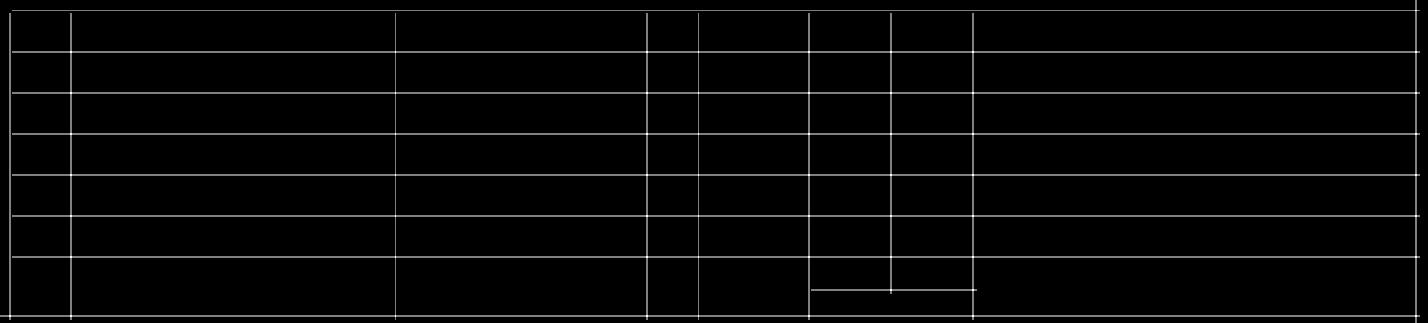

In [249]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.

# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
print(kernel)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

img_vh_pil = Image.fromarray(img_vh)

display(img_vh_pil) 


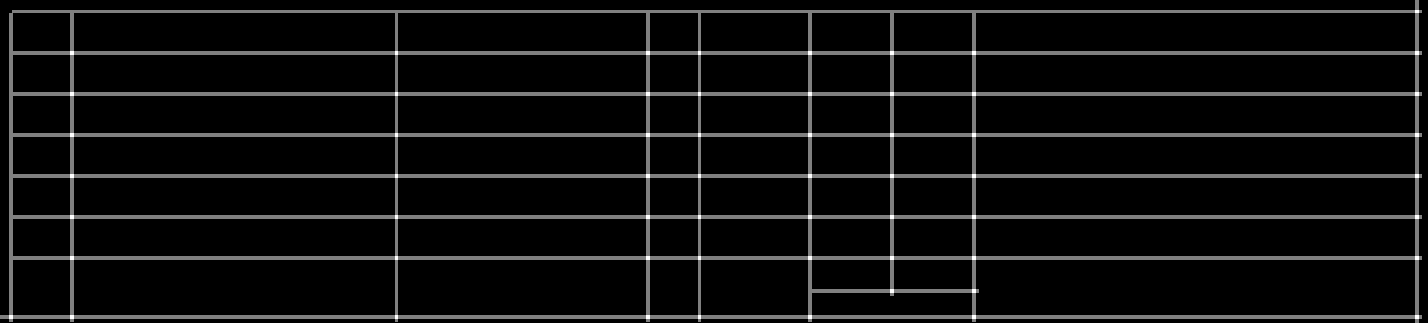

In [279]:
img_vh_e = cv2.erode(img_vh, kernel, iterations=2)
img_vh_d = cv2.dilate(img_vh, kernel, iterations=2)
img_vh_dd = cv2.dilate(img_vh_e, kernel, iterations=2)

img_vh_d_pil = Image.fromarray(img_vh_d)

display(img_vh_d_pil)


In [280]:
# Detect contours for following box detection
contours_1, hierarchy_1 = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_2, hierarchy_2 = cv2.findContours(img_vh_e, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_3, hierarchy_3 = cv2.findContours(img_vh_d, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_4, hierarchy_4 = cv2.findContours(img_vh_dd, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print(len(contours_1), len(contours_2), len(contours_3), len(contours_4))

43 0 58 0


In [281]:
contours_3[0].shape

(106, 1, 2)

In [282]:
print(xx_gray.shape)
boxes = np.zeros((len(contours_3), 4))

for i in range(len(contours_3)):
    
    cnt = contours_3[i]
    x, y, w, h = cv2.boundingRect(cnt)
    boxes[i, 0] = x
    boxes[i, 1] = y
    boxes[i, 2] = w
    boxes[i, 3] = h
    

(323, 1428)


In [283]:
boxes

array([[   0.,    0., 1422.,  323.],
       [ 811.,  292.,  162.,   24.],
       [ 975.,  259.,  441.,   57.],
       [ 893.,  259.,   80.,   31.],
       [ 811.,  259.,   80.,   31.],
       [ 700.,  259.,  109.,   57.],
       [ 649.,  259.,   50.,   57.],
       [ 397.,  259.,  250.,   57.],
       [  73.,  259.,  323.,   57.],
       [  12.,  259.,   59.,   57.],
       [ 975.,  218.,  441.,   39.],
       [ 893.,  218.,   80.,   39.],
       [ 811.,  218.,   80.,   39.],
       [ 700.,  218.,  109.,   39.],
       [ 649.,  218.,   50.,   39.],
       [ 397.,  218.,  250.,   39.],
       [  73.,  218.,  323.,   39.],
       [  12.,  218.,   59.,   39.],
       [ 975.,  177.,  441.,   39.],
       [ 893.,  177.,   80.,   39.],
       [ 811.,  177.,   80.,   39.],
       [ 700.,  177.,  109.,   39.],
       [ 649.,  177.,   50.,   39.],
       [ 397.,  177.,  250.,   39.],
       [  73.,  177.,  323.,   39.],
       [  12.,  177.,   59.,   39.],
       [ 975.,  136.,  441.,   39.],
 

In [130]:
# boxes_exp = np.zeros((len(contours_3), 4))

boxes_exp = []

for i in range(len(contours_3)):
    
    cnt = contours_3[i]
    boxes_exp.append(cv2.boundingRect(cnt))

In [132]:
print(type(boxes_exp[0]))
boxes_exp

<class 'tuple'>


[(0, 0, 1385, 216),
 (1216, 179, 168, 28),
 (1297, 144, 87, 34),
 (1216, 144, 80, 34),
 (1107, 144, 108, 63),
 (1052, 144, 55, 63),
 (853, 144, 199, 63),
 (71, 144, 781, 63),
 (13, 144, 57, 63),
 (1297, 100, 87, 43),
 (1216, 100, 80, 43),
 (1107, 100, 108, 43),
 (1052, 100, 55, 43),
 (853, 100, 199, 43),
 (71, 100, 781, 43),
 (13, 100, 57, 43),
 (1297, 56, 87, 43),
 (1216, 56, 80, 43),
 (1107, 56, 108, 43),
 (1052, 56, 55, 43),
 (853, 56, 199, 43),
 (71, 56, 781, 43),
 (13, 56, 57, 43),
 (1297, 12, 87, 43),
 (1216, 12, 80, 43),
 (1107, 12, 108, 43),
 (1052, 12, 55, 43),
 (853, 12, 199, 43),
 (71, 12, 781, 43),
 (13, 12, 57, 43)]

In [116]:
xx_gray.shape

(216, 1393)

In [284]:
boxes_1 = boxes[1:]   ## in format x, y, w, h
boxes_1

array([[811., 292., 162.,  24.],
       [975., 259., 441.,  57.],
       [893., 259.,  80.,  31.],
       [811., 259.,  80.,  31.],
       [700., 259., 109.,  57.],
       [649., 259.,  50.,  57.],
       [397., 259., 250.,  57.],
       [ 73., 259., 323.,  57.],
       [ 12., 259.,  59.,  57.],
       [975., 218., 441.,  39.],
       [893., 218.,  80.,  39.],
       [811., 218.,  80.,  39.],
       [700., 218., 109.,  39.],
       [649., 218.,  50.,  39.],
       [397., 218., 250.,  39.],
       [ 73., 218., 323.,  39.],
       [ 12., 218.,  59.,  39.],
       [975., 177., 441.,  39.],
       [893., 177.,  80.,  39.],
       [811., 177.,  80.,  39.],
       [700., 177., 109.,  39.],
       [649., 177.,  50.,  39.],
       [397., 177., 250.,  39.],
       [ 73., 177., 323.,  39.],
       [ 12., 177.,  59.,  39.],
       [975., 136., 441.,  39.],
       [893., 136.,  80.,  39.],
       [811., 136.,  80.,  39.],
       [700., 136., 109.,  39.],
       [649., 136.,  50.,  39.],
       [39

In [117]:
## If required followings are to be used :
"""
boxes_sorted = boxes[boxes[:,2].argsort()[::-1]] ## sorting 2-d array in reverse order ([::-1]) on col 2 ([:,2])
boxes_semifinal = boxes_sorted[boxes_sorted[:, -1] > 10]  ## last col. i.e. height values less than 10
boxes_final = boxes_semifinal[boxes_semifinal[:, 2] > 10]  ## 3rd col. i.e. width values less than 10

boxes_final
"""

'\nboxes_sorted = boxes[boxes[:,2].argsort()[::-1]] ## sorting 2-d array in reverse order ([::-1]) on col 2 ([:,2])\nboxes_semifinal = boxes_sorted[boxes_sorted[:, -1] > 10]  ## last col. i.e. height values less than 10\nboxes_final = boxes_semifinal[boxes_semifinal[:, 2] > 10]  ## 3rd col. i.e. width values less than 10\n\nboxes_final\n'

40.0


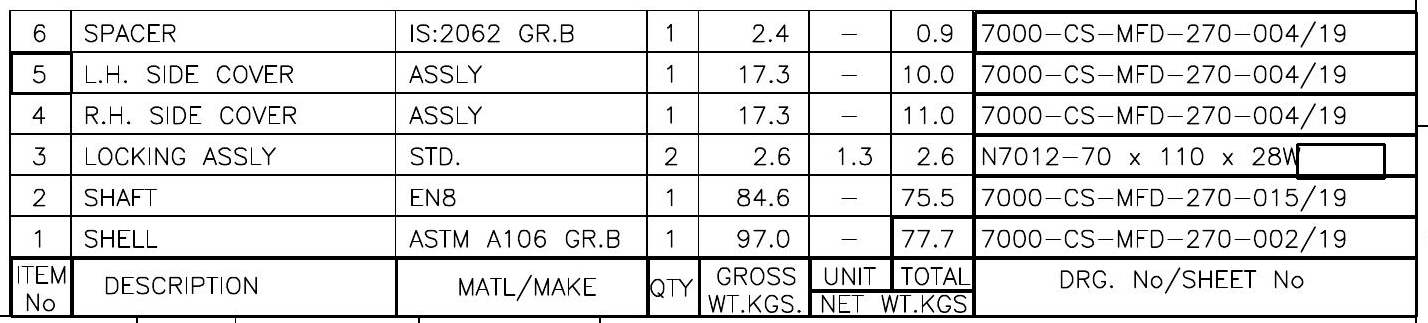

In [285]:
aa = boxes_1.tolist()
i = 49
bb = xx_gray

#yy = xx[int(aa[i][1]):int(aa[i][1] + aa[i][3]), int(aa[i][0]):int(aa[i][0] + aa[i][2])]

cv2.rectangle(bb, (int(aa[i][0]), int(aa[i][1])), (int(aa[i][0] + aa[i][2]), int(aa[i][1] + aa[i][3])), (0,0,255), 2)

#yy_pil = Image.fromarray(yy)

yy_pil = Image.fromarray(bb)
print(aa[i][3])
display(yy_pil) 

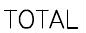

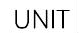

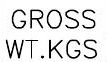

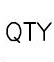

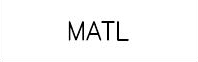

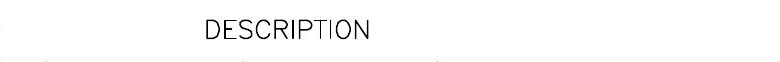

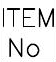

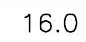

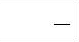

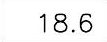

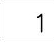

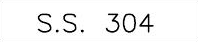

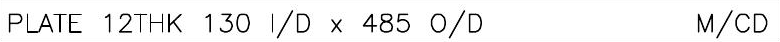

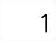

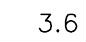

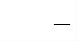

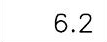

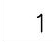

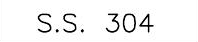

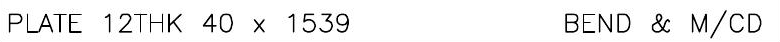

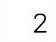

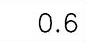

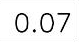

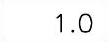

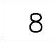

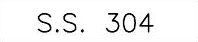

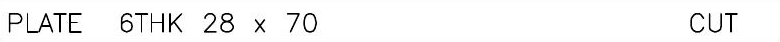

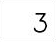

In [194]:
aa = boxes_1.tolist()

for i in range(len(aa)):
    
    yy = xx[int(aa[i][1]):int(aa[i][1] + aa[i][3]-1), int(aa[i][0]):int(aa[i][0] + aa[i][2]-1)]

    yy_pil = Image.fromarray(yy)

    display(yy_pil) 

In [122]:
i = 1
qq = xx_gray[int(aa[i][1]):int(aa[i][1] + aa[i][3]), int(aa[i][0]):int(aa[i][0] + aa[i][2])]
text_1 = pytesseract.image_to_string(qq)
print(text_1)

In [189]:
for i in range(len(aa)):
    
#    thresh, xx_gray_1 = cv2.threshold(xx_gray,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    yy_gray = xx_gray[int(aa[i][1]):int(aa[i][1] + aa[i][3]), int(aa[i][0]):int(aa[i][0] + aa[i][2])]
    
    text = pytesseract.image_to_string(yy_gray)

    print(text)

TOTAL
UNIT
GROSS
WT.KGS
QTY
MATL
DESCRIPTION
|TEM
16.0

18.6

S.5. 304
PLATE 12THK 130 1/D x 485 O/D

M/CD

3.6

6.2

S.5. 304
PLATE 12THK 40 x 1539

BEND & M/CD

0.6
0.07
1.0

S.S. 304
PLATE

6THK 28 x 70



In [203]:
print(boxes_1.shape)

## Find number of columns i.e. max occurance of any y value :

y_list = boxes_1[:, 1].tolist()

col_count_array = np.bincount(y_list)
col_count = col_count_array.max()

print(col_count)

# Now fid the Header row. In drawings, header row is always at the bottom and cv2.boundingRect always starts,
# after the 1st row, from bottom right

# So, y value of boxes[1] is the bottom_most-right_most  cell y value.

y_bmrm_cell = boxes_1[0][1]

num_col = y_list.count(y_bmrm_cell)

print(num_col)

if num_col == col_count:
    
    y_header_row = y_bmrm_cell
    
    print(y_header_row)
    
else:
        
    bom_boxes_1 = boxes_1[1:]  ## remove 1st row for bom consideration
    y_next_cell = boxes_1[1][1]

    num_col = y_list.count(y_next_cell)

    print(num_col)

    if num_col == col_count:
    
        y_header_row = y_next_cell

    print(y_header_row)

header_boxes = boxes_1[boxes_1[:, 1] == y_header_row]

print(bom_boxes_1.shape)

header_boxes


(29, 4)
7
1
7
144.0
(28, 4)


array([[1297.,  144.,   87.,   34.],
       [1216.,  144.,   80.,   34.],
       [1107.,  144.,  108.,   63.],
       [1052.,  144.,   55.,   63.],
       [ 853.,  144.,  199.,   63.],
       [  71.,  144.,  781.,   63.],
       [  13.,  144.,   57.,   63.]])

In [286]:
## for image_id = 23
print(boxes_1.shape)

## Find number of columns i.e. max occurance of any y value :

y_list = boxes_1[:, 1].tolist()

col_count_array = np.bincount(y_list)
col_count = col_count_array.max()

print(col_count)

# Now fid the Header row. In drawings, header row is always at the bottom and cv2.boundingRect always starts,
# after the 1st row, from bottom right

# So, y value of boxes[1] is the bottom_most-right_most  cell y value.

y_bmrm_cell = boxes_1[0][1]

num_col = y_list.count(y_bmrm_cell)

print(num_col)

if num_col == col_count:
    
    y_header_row = y_bmrm_cell
    
    print(y_header_row)
    
else:
        
    bom_boxes_1 = boxes_1[1:]  ## remove 1st row for bom consideration
    y_next_cell = boxes_1[1][1]

    num_col = y_list.count(y_next_cell)

    print(num_col)

    if num_col == col_count:
    
        y_header_row = y_next_cell

    print(y_header_row)

header_boxes = boxes_1[boxes_1[:, 1] == y_header_row]

print(bom_boxes_1.shape)

header_boxes


(57, 4)
8
1
8
259.0
(56, 4)


array([[975., 259., 441.,  57.],
       [893., 259.,  80.,  31.],
       [811., 259.,  80.,  31.],
       [700., 259., 109.,  57.],
       [649., 259.,  50.,  57.],
       [397., 259., 250.,  57.],
       [ 73., 259., 323.,  57.],
       [ 12., 259.,  59.,  57.]])

In [205]:
aa = header_boxes
header_text = []

for i in range(len(aa)):
    
#    thresh, xx_gray_1 = cv2.threshold(xx_gray,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    yy_gray = xx_gray[int(aa[i][1]):int(aa[i][1] + aa[i][3]), int(aa[i][0]):int(aa[i][0] + aa[i][2])]

    header_text.append(pytesseract.image_to_string(yy_gray))
    
serialised_header_text = header_text[::-1]
print(serialised_header_text)
print(header_text)


['|TEM', 'DESCRIPTION', 'MATL', 'QTY', 'GROSS\nWT.KGS', 'UNIT', 'TOTAL']
['TOTAL', 'UNIT', 'GROSS\nWT.KGS', 'QTY', 'MATL', 'DESCRIPTION', '|TEM']


In [287]:
## for image_id = 23
aa = header_boxes
header_text = []

for i in range(len(aa)):
    
#    thresh, xx_gray_1 = cv2.threshold(xx_gray,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    yy_gray = xx_gray[int(aa[i][1]):int(aa[i][1] + aa[i][3]), int(aa[i][0]):int(aa[i][0] + aa[i][2])]

    header_text.append(pytesseract.image_to_string(yy_gray))
    
serialised_header_text = header_text[::-1]
print(serialised_header_text)
print(header_text)


['ITEM\nNo', 'DESCRIPTION', 'MATL/MAKE', 'QTY', 'GROSS\nWT.KCGS.', 'UNIT', 'TOTAL', 'DRG. No/SHEET No']
['DRG. No/SHEET No', 'TOTAL', 'UNIT', 'GROSS\nWT.KCGS.', 'QTY', 'MATL/MAKE', 'DESCRIPTION', 'ITEM\nNo']


In [234]:
bom_boxes = bom_boxes_1[bom_boxes_1[:, 1] != y_header_row]

print(bom_boxes.shape)

print(bom_boxes)

y_unique = np.unique(bom_boxes[:,1])
y_unique = y_unique[::-1]

print(y_unique)

bom_text = []

for i in y_unique:
    
    bom_sub_text = []
    
    aa = bom_boxes[bom_boxes[:, 1] == i]

    for i in range(len(aa)):
    
#        thresh, xx_gray_1 = cv2.threshold(xx_gray,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
        yy_gray = xx_gray[int(aa[i][1]):int(aa[i][1] + aa[i][3]), int(aa[i][0]):int(aa[i][0] + aa[i][2])]
    
        text = pytesseract.image_to_string(yy_gray, config='--psm 9 --oem 3')
        
        bom_sub_text.append(text)
        
#        bom_sub_text.append(text)
    
    bom_sub_text_rev = bom_sub_text[::-1]
    bom_text.append(bom_sub_text_rev)
    
print(bom_text)
print('=============================')
print(bom_text[0])

#text = pytesseract.image_to_string(pixels, config='digits')

(21, 4)
[[1297.  100.   87.   43.]
 [1216.  100.   80.   43.]
 [1107.  100.  108.   43.]
 [1052.  100.   55.   43.]
 [ 853.  100.  199.   43.]
 [  71.  100.  781.   43.]
 [  13.  100.   57.   43.]
 [1297.   56.   87.   43.]
 [1216.   56.   80.   43.]
 [1107.   56.  108.   43.]
 [1052.   56.   55.   43.]
 [ 853.   56.  199.   43.]
 [  71.   56.  781.   43.]
 [  13.   56.   57.   43.]
 [1297.   12.   87.   43.]
 [1216.   12.   80.   43.]
 [1107.   12.  108.   43.]
 [1052.   12.   55.   43.]
 [ 853.   12.  199.   43.]
 [  71.   12.  781.   43.]
 [  13.   12.   57.   43.]]
[100.  56.  12.]
[['1', 'PLATE 12THK 130 I/D x 485 O/D ________ M/CD', 'S.5. 304', '1', '18.6', 'a«', '16.0'], ['2', 'PLATE 12THK 40 x 1539 ________ BEND & M/CD', 'S.5. 304', '1', '6.2', '—', '3.6'], ['3', 'PLATE 6THK 28 x 70 _ _ _ _ _ _ _ _ CUuf', 'S.S. 304', '8', '1.0', '0.07', '0.6']]
['1', 'PLATE 12THK 130 I/D x 485 O/D ________ M/CD', 'S.5. 304', '1', '18.6', 'a«', '16.0']


In [236]:
bom_boxes = bom_boxes_1[bom_boxes_1[:, 1] != y_header_row]

print(bom_boxes.shape)

print(bom_boxes)

y_unique = np.unique(bom_boxes[:,1])
y_unique = y_unique[::-1]

print(y_unique)

bom_text = []

for i in y_unique:
    
    bom_sub_text = []
    
    aa = bom_boxes[bom_boxes[:, 1] == i]

    for i in range(len(aa)):
    
#        thresh, xx_gray_1 = cv2.threshold(xx_gray,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
        yy_gray = xx_gray[int(aa[i][1]):int(aa[i][1] + aa[i][3]), int(aa[i][0]):int(aa[i][0] + aa[i][2])]
    
        text = pytesseract.image_to_string(yy_gray, config='--psm 9 --oem 3')
        
        bom_sub_text.append(text)
        
#        bom_sub_text.append(text)
    
    bom_sub_text_rev = bom_sub_text[::-1]
    bom_text.append(bom_sub_text_rev)
    
print(bom_text)
print('=============================')
print(bom_text[0])

#text = pytesseract.image_to_string(pixels, config='digits')

(21, 4)
[[1297.  100.   87.   43.]
 [1216.  100.   80.   43.]
 [1107.  100.  108.   43.]
 [1052.  100.   55.   43.]
 [ 853.  100.  199.   43.]
 [  71.  100.  781.   43.]
 [  13.  100.   57.   43.]
 [1297.   56.   87.   43.]
 [1216.   56.   80.   43.]
 [1107.   56.  108.   43.]
 [1052.   56.   55.   43.]
 [ 853.   56.  199.   43.]
 [  71.   56.  781.   43.]
 [  13.   56.   57.   43.]
 [1297.   12.   87.   43.]
 [1216.   12.   80.   43.]
 [1107.   12.  108.   43.]
 [1052.   12.   55.   43.]
 [ 853.   12.  199.   43.]
 [  71.   12.  781.   43.]
 [  13.   12.   57.   43.]]
[100.  56.  12.]
[['1', 'PLATE 12THK 130 I/D x 485 O/D ________ M/CD', 'S.5. 304', '1', '18.6', 'a«', '16.0'], ['2', 'PLATE 12THK 40 x 1539 ________ BEND & M/CD', 'S.5. 304', '1', '6.2', '—', '3.6'], ['3', 'PLATE 6THK 28 x 70 _ _ _ _ _ _ _ _ CUuf', 'S.S. 304', '8', '1.0', '0.07', '0.6']]
['1', 'PLATE 12THK 130 I/D x 485 O/D ________ M/CD', 'S.5. 304', '1', '18.6', 'a«', '16.0']


In [289]:
## for image_id = 23
bom_boxes = bom_boxes_1[bom_boxes_1[:, 1] != y_header_row]

print(bom_boxes.shape)

print(bom_boxes)

y_unique = np.unique(bom_boxes[:,1])
y_unique = y_unique[::-1]

print(y_unique)

bom_text = []

for i in y_unique:
    
    bom_sub_text = []
    
    aa = bom_boxes[bom_boxes[:, 1] == i]

    for i in range(len(aa)):
    
#        thresh, xx_gray_1 = cv2.threshold(xx_gray,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
        yy_gray = xx_gray[int(aa[i][1]):int(aa[i][1] + aa[i][3]), int(aa[i][0]):int(aa[i][0] + aa[i][2])]
    
        text = pytesseract.image_to_string(yy_gray, config='--psm 10 --oem 3')
        
        bom_sub_text.append(text)
        
#        bom_sub_text.append(text)
    
    bom_sub_text_rev = bom_sub_text[::-1]
    bom_text.append(bom_sub_text_rev)
    
print(bom_text)
print('=============================')
print(bom_text[0])

#text = pytesseract.image_to_string(pixels, config='digits')

(48, 4)
[[975. 218. 441.  39.]
 [893. 218.  80.  39.]
 [811. 218.  80.  39.]
 [700. 218. 109.  39.]
 [649. 218.  50.  39.]
 [397. 218. 250.  39.]
 [ 73. 218. 323.  39.]
 [ 12. 218.  59.  39.]
 [975. 177. 441.  39.]
 [893. 177.  80.  39.]
 [811. 177.  80.  39.]
 [700. 177. 109.  39.]
 [649. 177.  50.  39.]
 [397. 177. 250.  39.]
 [ 73. 177. 323.  39.]
 [ 12. 177.  59.  39.]
 [975. 136. 441.  39.]
 [893. 136.  80.  39.]
 [811. 136.  80.  39.]
 [700. 136. 109.  39.]
 [649. 136.  50.  39.]
 [397. 136. 250.  39.]
 [ 73. 136. 323.  39.]
 [ 12. 136.  59.  39.]
 [975.  95. 441.  39.]
 [893.  95.  80.  39.]
 [811.  95.  80.  39.]
 [700.  95. 109.  39.]
 [649.  95.  50.  39.]
 [397.  95. 250.  39.]
 [ 73.  95. 323.  39.]
 [ 12.  95.  59.  39.]
 [975.  54. 441.  39.]
 [893.  54.  80.  39.]
 [811.  54.  80.  39.]
 [700.  54. 109.  39.]
 [649.  54.  50.  39.]
 [397.  54. 250.  39.]
 [ 73.  54. 323.  39.]
 [ 12.  54.  59.  39.]
 [975.  12. 441.  40.]
 [893.  12.  80.  40.]
 [811.  12.  80.  40.]
 [7

In [235]:
#Creating a dataframe of the generated OCR list
arr = np.array(bom_text)
dataframe = pd.DataFrame(arr.reshape(3,7), columns = serialised_header_text)
#print(dataframe)
#data = dataframe.style.set_properties(align="left")
dataframe.head()

,|TEM,DESCRIPTION,MATL,QTY,GROSS WT.KGS,UNIT,TOTAL
0,1,PLATE 12THK 130 I/D x 485 O/D ________ M/CD,S.5. 304,1,18.6,a«,16.0
1,2,PLATE 12THK 40 x 1539 ________ BEND & M/CD,S.5. 304,1,6.2,—,3.6
2,3,PLATE 6THK 28 x 70 _ _ _ _ _ _ _ _ CUuf,S.S. 304,8,1.0,0.07,0.6


In [291]:
#Creating a dataframe of the generated OCR list
arr = np.array(bom_text)
dataframe = pd.DataFrame(arr.reshape(6,8), columns = serialised_header_text)
#print(dataframe)
#data = dataframe.style.set_properties(align="left")
dataframe.head()

,ITEM No,DESCRIPTION,MATL/MAKE,QTY,GROSS WT.KCGS.,UNIT,TOTAL,DRG. No/SHEET No
0,o4.,SHELL,ASTM A106 GR.B,o1,97.0,| s |,,7000—CS—MFD—270—002/19
1,i,SHAFT,EN8,Li,84.6,| s |,75.9,7000—CS—MFD—270—015/19
2,30,LOCKING ASSLY,STD.,2o,2.6,—4.80,—2.6),
3,—4 0,R.H. SIDE COVER,ASSLY,30,17.3,_ s _,11.0,7000—CS—MFD—270—004/19
4,,L.H. SIDE COVER,ASSLY,8,17.$,se l,10.0,7000—CS—MFD—270—004/19


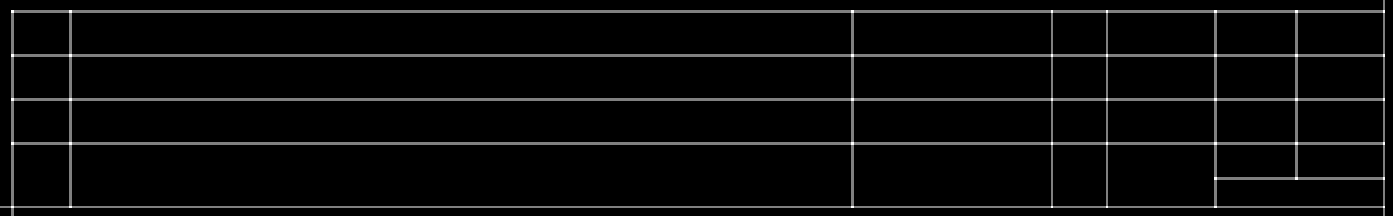

In [123]:
img_vh_d_pil = Image.fromarray(img_vh_d)
display(img_vh_d_pil)

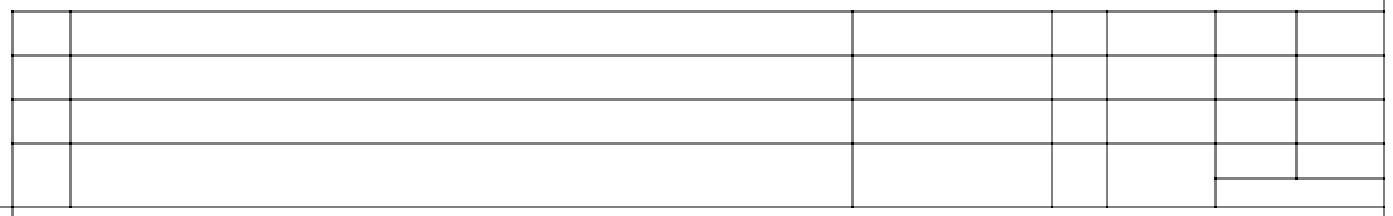

In [125]:
img_vh_d_inv_pil = Image.fromarray(~img_vh_d)  ## before img_vh_d it is not minus sign
display(img_vh_d_inv_pil)

In [94]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
len(contours)

307

In [99]:
print(contours[0].shape)
print(contours[1].shape)
print(contours[2].shape)
print(contours[10].shape)
      
print(contours[100].shape)
print(contours[200].shape)
print(contours[300].shape)
print(contours[306].shape)

(46, 1, 2)
(10, 1, 2)
(10, 1, 2)
(4, 1, 2)
(4, 1, 2)
(4, 1, 2)
(4, 1, 2)
(52, 1, 2)


In [100]:
print(contours[10])

[[[1381 1568]]

 [[1381 1606]]

 [[1867 1606]]

 [[1867 1568]]]


In [62]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "left-to-right":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method= "top-to-bottom")

In [63]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#Get mean of heights
mean = np.mean(heights)

In [135]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours_3:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(xx_gray,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])



In [141]:
#Creating a list of heights for all detected boxes
heights = [box[i][3] for i in range(len(box))]
#Get mean of heights
mean = np.mean(heights)

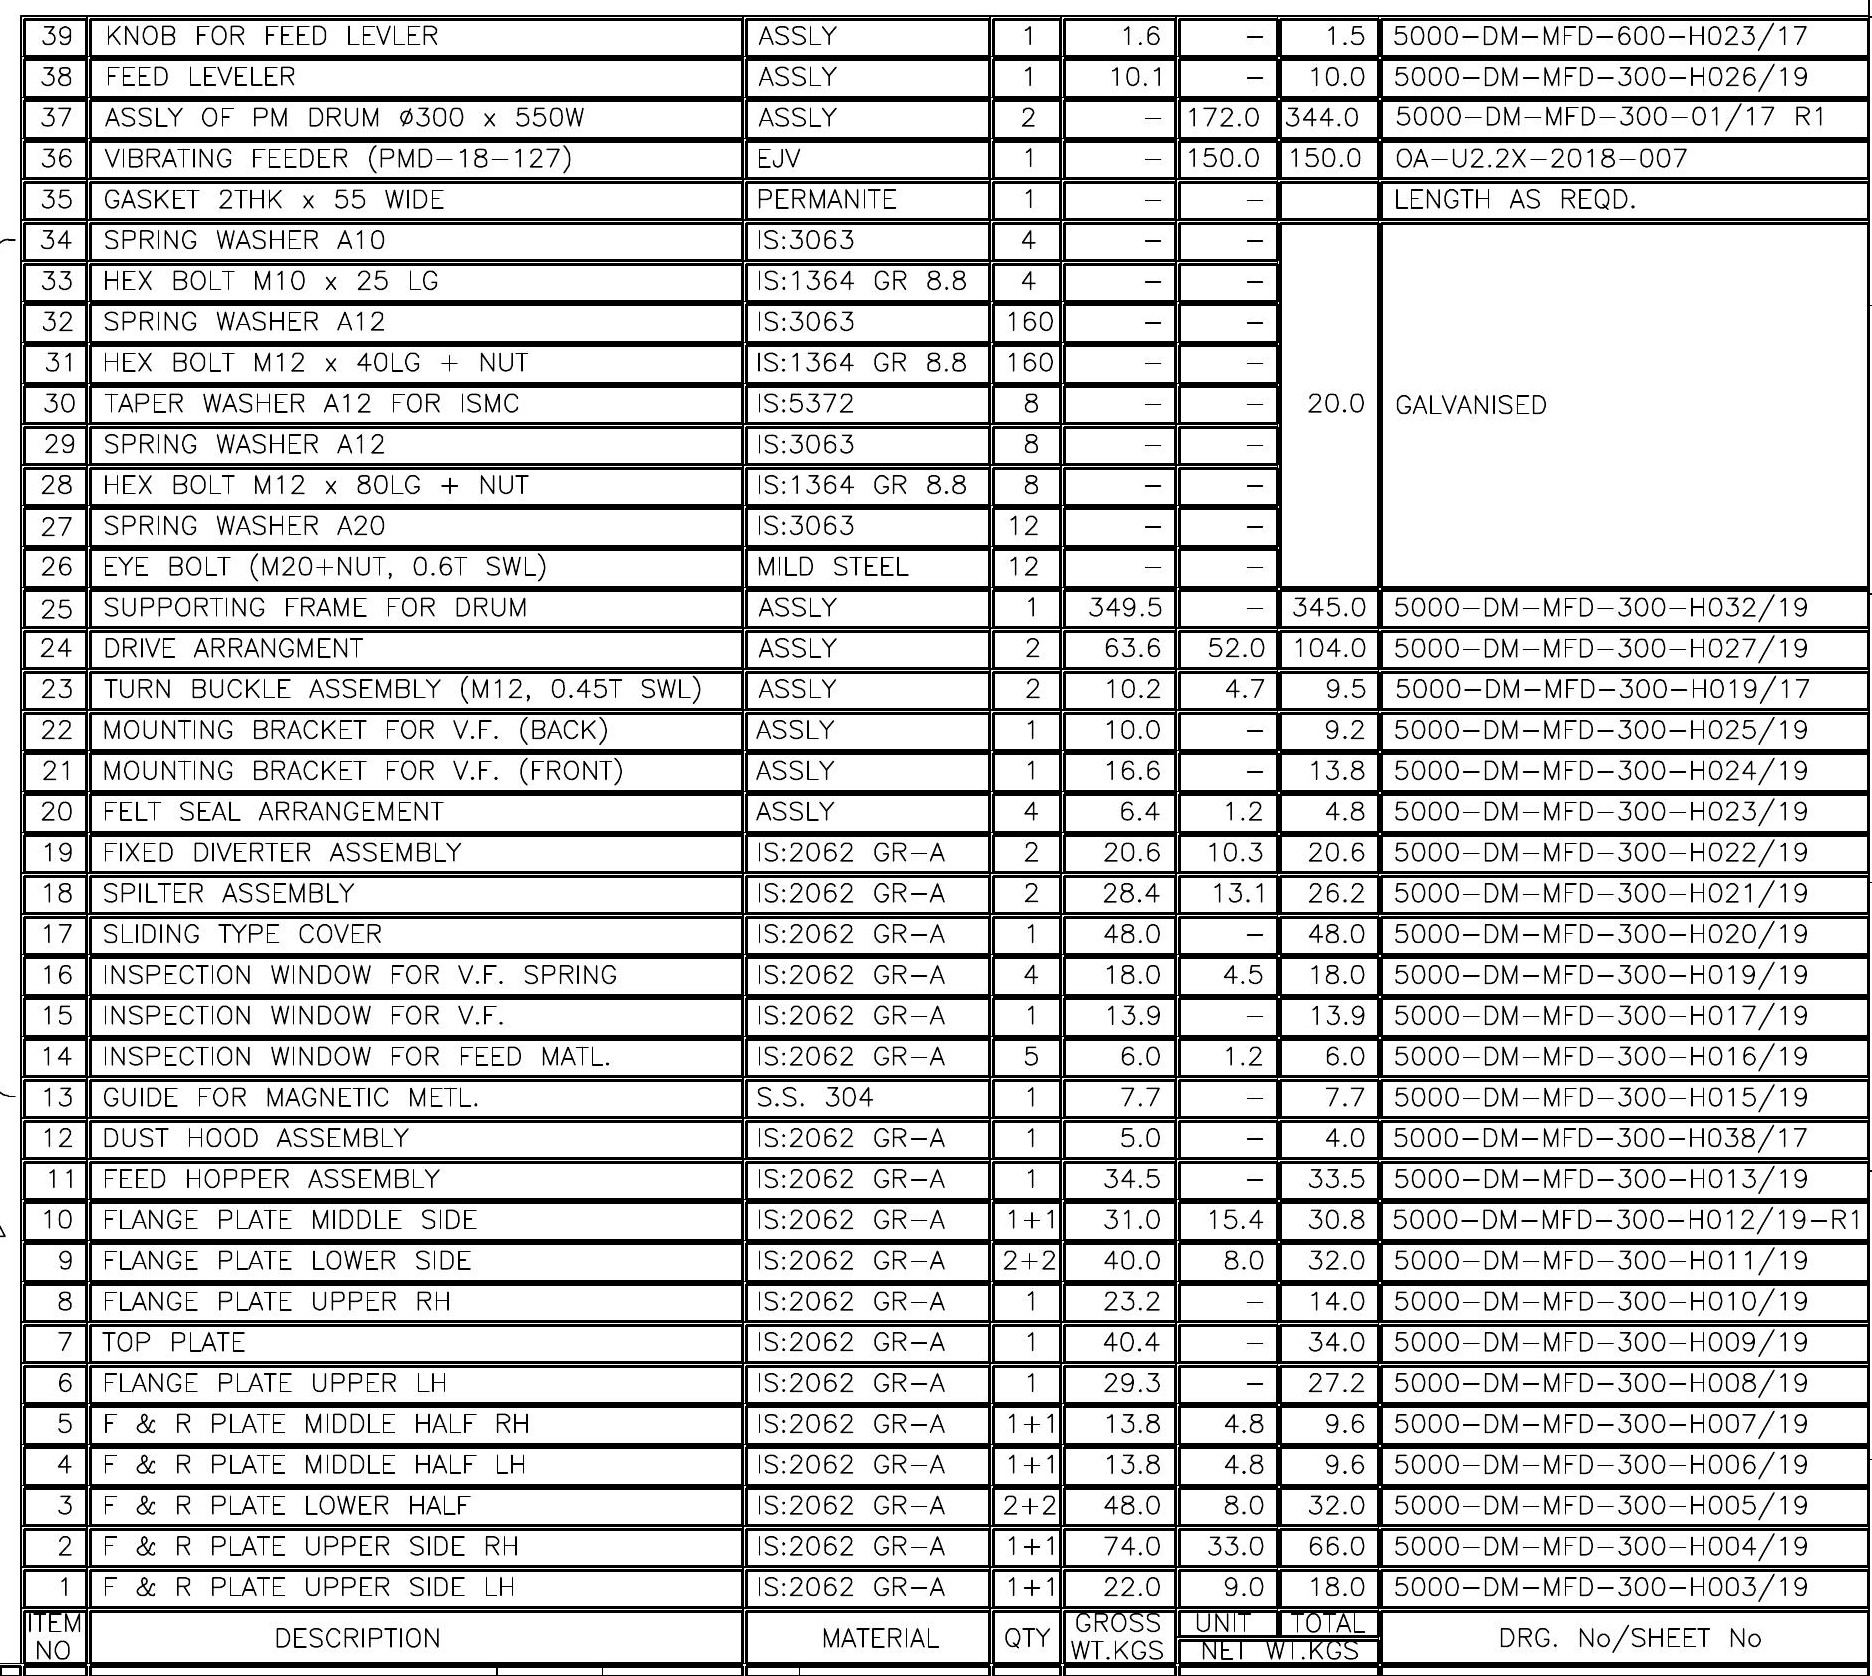

In [65]:
image_pil = Image.fromarray(image)

display(image_pil) 


In [139]:
print(len(box))
box

29


[[1216, 179, 168, 28],
 [1297, 144, 87, 34],
 [1216, 144, 80, 34],
 [1107, 144, 108, 63],
 [1052, 144, 55, 63],
 [853, 144, 199, 63],
 [71, 144, 781, 63],
 [13, 144, 57, 63],
 [1297, 100, 87, 43],
 [1216, 100, 80, 43],
 [1107, 100, 108, 43],
 [1052, 100, 55, 43],
 [853, 100, 199, 43],
 [71, 100, 781, 43],
 [13, 100, 57, 43],
 [1297, 56, 87, 43],
 [1216, 56, 80, 43],
 [1107, 56, 108, 43],
 [1052, 56, 55, 43],
 [853, 56, 199, 43],
 [71, 56, 781, 43],
 [13, 56, 57, 43],
 [1297, 12, 87, 43],
 [1216, 12, 80, 43],
 [1107, 12, 108, 43],
 [1052, 12, 55, 43],
 [853, 12, 199, 43],
 [71, 12, 781, 43],
 [13, 12, 57, 43]]

In [142]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[1216, 179, 168, 28], [1297, 144, 87, 34], [1216, 144, 80, 34], [1107, 144, 108, 63], [1052, 144, 55, 63], [853, 144, 199, 63], [71, 144, 781, 63], [13, 144, 57, 63], [1297, 100, 87, 43], [1216, 100, 80, 43], [1107, 100, 108, 43], [1052, 100, 55, 43], [853, 100, 199, 43], [71, 100, 781, 43], [13, 100, 57, 43], [1297, 56, 87, 43], [1216, 56, 80, 43], [1107, 56, 108, 43], [1052, 56, 55, 43], [853, 56, 199, 43], [71, 56, 781, 43], [13, 56, 57, 43], [1297, 12, 87, 43], [1216, 12, 80, 43], [1107, 12, 108, 43], [1052, 12, 55, 43], [853, 12, 199, 43], [71, 12, 781, 43], [13, 12, 57, 43]]
[[[1216, 179, 168, 28], [1297, 144, 87, 34], [1216, 144, 80, 34], [1107, 144, 108, 63], [1052, 144, 55, 63], [853, 144, 199, 63], [71, 144, 781, 63], [13, 144, 57, 63], [1297, 100, 87, 43], [1216, 100, 80, 43], [1107, 100, 108, 43], [1052, 100, 55, 43], [853, 100, 199, 43], [71, 100, 781, 43], [13, 100, 57, 43], [1297, 56, 87, 43], [1216, 56, 80, 43], [1107, 56, 108, 43], [1052, 56, 55, 43], [853, 56, 199, 4

In [163]:
print(type(row))
print(len(row))
print(len(row[0]))
print(row[0])
print(row[0][0])

row

<class 'list'>
1
29
[[1216, 179, 168, 28], [1297, 144, 87, 34], [1216, 144, 80, 34], [1107, 144, 108, 63], [1052, 144, 55, 63], [853, 144, 199, 63], [71, 144, 781, 63], [13, 144, 57, 63], [1297, 100, 87, 43], [1216, 100, 80, 43], [1107, 100, 108, 43], [1052, 100, 55, 43], [853, 100, 199, 43], [71, 100, 781, 43], [13, 100, 57, 43], [1297, 56, 87, 43], [1216, 56, 80, 43], [1107, 56, 108, 43], [1052, 56, 55, 43], [853, 56, 199, 43], [71, 56, 781, 43], [13, 56, 57, 43], [1297, 12, 87, 43], [1216, 12, 80, 43], [1107, 12, 108, 43], [1052, 12, 55, 43], [853, 12, 199, 43], [71, 12, 781, 43], [13, 12, 57, 43]]
[1216, 179, 168, 28]


[[[1216, 179, 168, 28],
  [1297, 144, 87, 34],
  [1216, 144, 80, 34],
  [1107, 144, 108, 63],
  [1052, 144, 55, 63],
  [853, 144, 199, 63],
  [71, 144, 781, 63],
  [13, 144, 57, 63],
  [1297, 100, 87, 43],
  [1216, 100, 80, 43],
  [1107, 100, 108, 43],
  [1052, 100, 55, 43],
  [853, 100, 199, 43],
  [71, 100, 781, 43],
  [13, 100, 57, 43],
  [1297, 56, 87, 43],
  [1216, 56, 80, 43],
  [1107, 56, 108, 43],
  [1052, 56, 55, 43],
  [853, 56, 199, 43],
  [71, 56, 781, 43],
  [13, 56, 57, 43],
  [1297, 12, 87, 43],
  [1216, 12, 80, 43],
  [1107, 12, 108, 43],
  [1052, 12, 55, 43],
  [853, 12, 199, 43],
  [71, 12, 781, 43],
  [13, 12, 57, 43]]]

In [147]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol
countcol

29

In [148]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()


In [164]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    print('i = ', i)
    lis=[]
    for k in range(countcol):
#        print('k = ', k)
        lis.append([])
#        print(lis)
    for j in range(len(row[i])):
        print(j)
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        print(diff)
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

i =  0
k =  0
[[]]
k =  1
[[], []]
k =  2
[[], [], []]
k =  3
[[], [], [], []]
k =  4
[[], [], [], [], []]
k =  5
[[], [], [], [], [], []]
k =  6
[[], [], [], [], [], [], []]
k =  7
[[], [], [], [], [], [], [], []]
k =  8
[[], [], [], [], [], [], [], [], []]
k =  9
[[], [], [], [], [], [], [], [], [], []]
k =  10
[[], [], [], [], [], [], [], [], [], [], []]
k =  11
[[], [], [], [], [], [], [], [], [], [], [], []]
k =  12
[[], [], [], [], [], [], [], [], [], [], [], [], []]
k =  13
[[], [], [], [], [], [], [], [], [], [], [], [], [], []]
k =  14
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
k =  15
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
k =  16
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
k =  17
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
k =  18
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
k =  19
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],

In [160]:
print(len(finalboxes[0][0]))
print(finalboxes[0][0])

4
[[13, 144, 57, 63], [13, 100, 57, 43], [13, 56, 57, 43], [13, 12, 57, 43]]


In [151]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner= ''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
#                finalimg = bitnot[x:x+h, y:y+w]
                finalimg = xx_gray[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)


In [152]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)
data = dataframe.style.set_properties(align="left")
#Converting it in a excel-file
data.to_excel('/home/scar3crow/Downloads/output_2.xlsx')

dataframe.head(10)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,,,,,‘ DESCRIPTION |P|_ATE 12THK 130 I1/D x 485 O/...,,,,MATL S.S. 304 S.S. 304 S.S. 304,,...,,NET WT.KGS,,,,,,,,


In [153]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)
data = dataframe.style.set_properties(align="left")
#Converting it in a excel-file
data.to_excel('/home/scar3crow/Downloads/output_1.xlsx')

dataframe.head(10)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,,,,,‘ DESCRIPTION |P|_ATE 12THK 130 I1/D x 485 O/...,,,,MATL S.S. 304 S.S. 304 S.S. 304,,...,,NET WT.KGS,,,,,,,,
